# Computer Vision

Input is a Picture of the Plate.
And the Data for the Robot
Output are Trapezoids of the Plate and to which working zones there are assigned to.

## Starting with extraction all the information from the picture


## Libaries
First, import all the needed libraries:

In [1]:
import cv2
import numpy as np
import array

import seidel as sd
from descartes import PolygonPatch
from shapely.geometry import  Polygon
import ComputerVisionHeinz as cvh


from matplotlib import pyplot as plt
%matplotlib inline

## Import Image
*   Import the Image
*   Check if it is a valid Image
*   Show the Image

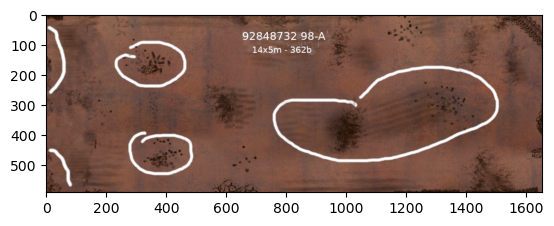

In [2]:
# Load the image
image = cv2.imread('panorama.png')

# Check if the image was loaded successfully
if image is None:
    print("Error: Failed to load the image.")
    exit()

# Show the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Filter the Picture for Contours
*   Delete everything that is not a Contour.
*   Check if the are of the contour is bigger then the Threshold area_size = 600.
*   Show the Image with the Contours.


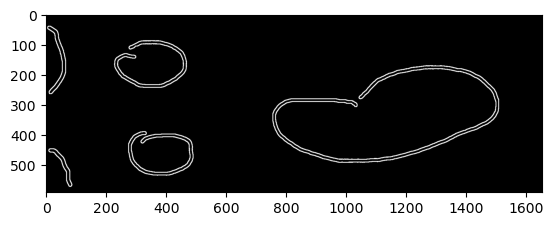

In [3]:
# Get the contours and a black Image with the contours drawn on it
grouped_contours, image_contours = cvh.get_grouped_contours(image, min_area=600)

# Show the countours on a black image
plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
plt.show()

### Make the Contours to closed Hulls

* Create a list of all the closed hulls
* Draw the hulls onto a black image

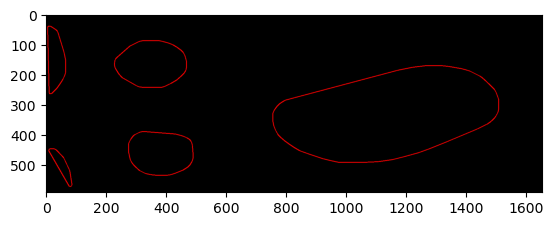

In [4]:
# Make the first hull closed
grouped_hulls, image_hulls = cvh.make_first_hull_closed(grouped_contours, image_contours)

# Show the hulls on a black image
plt.imshow(cv2.cvtColor(image_hulls, cv2.COLOR_BGR2RGB))
plt.show()

# Connect the Hulls to the Borders
* Check how close a Point of the Hull is to the Border by a threshold
* If the Point is close to the Border, connect the Point with the Border
* Draw the connected Hulls onto a black image

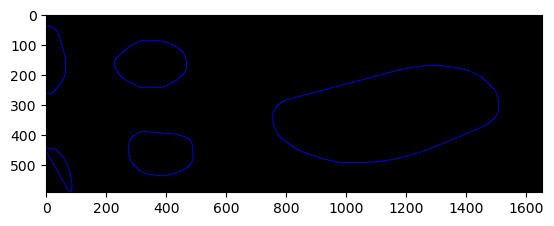

In [5]:
# Connect the hull to the border of the image
grouped_hulls_border, image_hulls_border = cvh.make_hull_connected_to_border(grouped_hulls, image_hulls)

# Show the hulls on a black image
plt.imshow(cv2.cvtColor(image_hulls_border, cv2.COLOR_BGR2RGB))
plt.show()

# Add the Corners to the Hulls
* If a Hull is connected to two Borders, add the Corners to the Hull

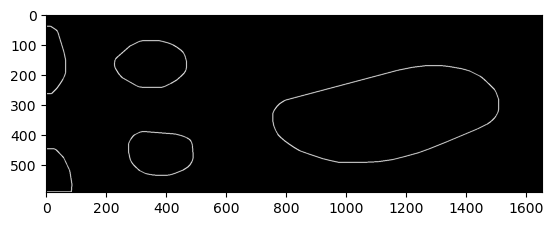

In [6]:
# Fill in the corners of the hulls
grouped_hulls_edges, image_hulls_corner = cvh.fill_corners(grouped_hulls_border, image_hulls_border)

# Show the hulls on a black image
plt.imshow(cv2.cvtColor(image_hulls_corner, cv2.COLOR_BGR2RGB))
plt.show()

# Extract the finished Polygones
* Extract the finished Polygones from the black image


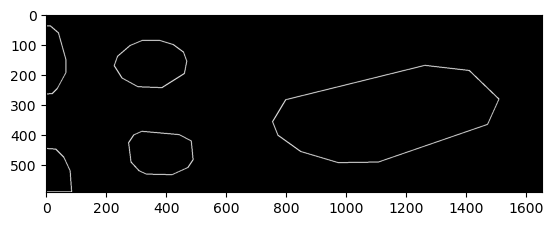

In [7]:
# Extract the finished hull
grouped_polynones_finished, image_finished_polynome = cvh.extract_finished_polynomes(image_hulls_corner)

# Show the hulls on a black image
plt.imshow(cv2.cvtColor(image_finished_polynome, cv2.COLOR_BGR2RGB))
plt.show()


# Make the Working Zones
* Make the working Zones
* return the size of the 4 working zones as well as 4 Cropped Images according to the working zones



[[(-727, -240), (827, 295)], [(-827, -195), (772, 295)], [(-827, -295), (727, 240)], [(-772, -295), (827, 195)]]
zone:  0
[(-727, -240), (827, 295)]
x1, y1:  100 55
x2, y2:  1654 590
zone:  1
[(-827, -195), (772, 295)]
x1, y1:  0 100
x2, y2:  1599 590
zone:  2
[(-827, -295), (727, 240)]
x1, y1:  0 0
x2, y2:  1554 535
zone:  3
[(-772, -295), (827, 195)]
x1, y1:  55 0
x2, y2:  1654 490


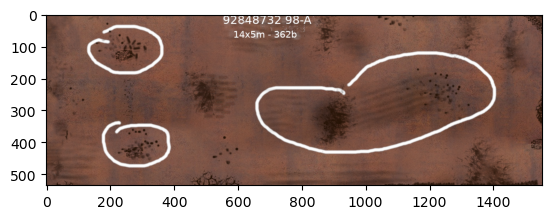

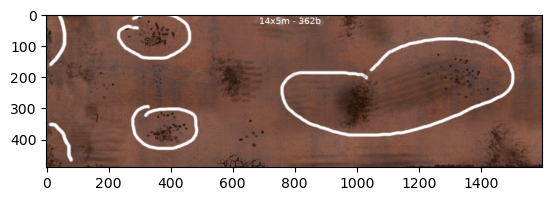

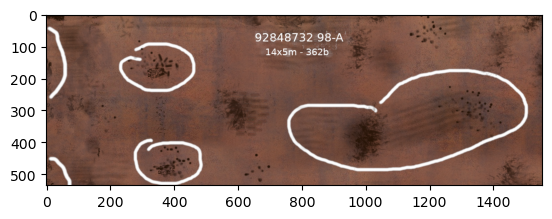

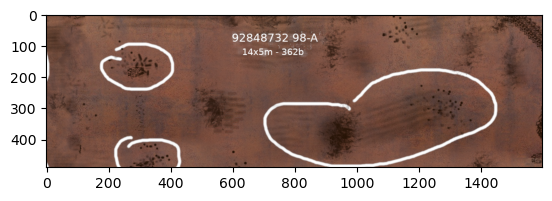

In [8]:
# Claculate the working zones like in the paper
z0, z90, z180, z270 = cvh.make_working_zones(image_finished_polynome)
working_zones = [z0, z90, z180, z270]

#For now its a mock up
h, w = image.shape[:2]
h, w = image.shape[0], image.shape[1]
h, w = int(h/2), int(w/2)
z0 = [(0,0),(w,h)]
z90 = [(0,0),(-w,-h)]
z180 = [(0,0),(-w,h)]
z270 = [(0,0),(w,-h)]
working_zones_mockup = [z0, z90, z180, z270]

#working_zones = working_zones_mockup
print(working_zones)

for i, zone in enumerate(working_zones):
    print("zone: ", i)
    print(zone)
    x1, y1 = zone[0]
    x2, y2 = zone[1]

    x1 = x1 + w
    y1 = y1 + h
    x2 = x2 + w
    y2 = y2 + h

    print("x1, y1: ", x1, y1)
    print("x2, y2: ", x2, y2)
    


for z in working_zones:
    image_cropped, _  = cvh.get_rectangle(image, z[0],z[1])
    plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
    plt.show()



# Add to working zone

# Get the Hulls of each Working zone
* get all hulls in each working zone
* we use a greedy algorithm
* we will start with the Working Zone1
* if a Contour is in that zone it will get classified as this working zone and will be removed from the list of all contours
* more this area will be cropped from the image
* and replaced with a black mask

* returns 
    *   the hulls of each working zone
    *   the complete image with the hulls of each working zone in different colors
    *   lift of cropped images of each working zone with hulls







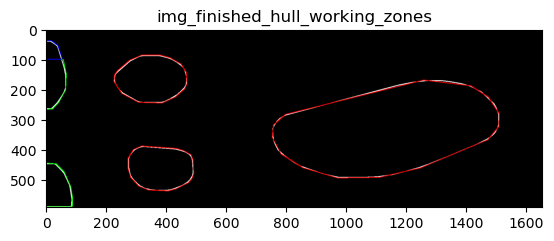

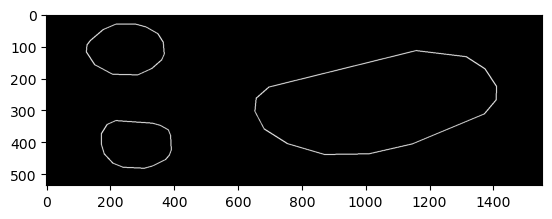

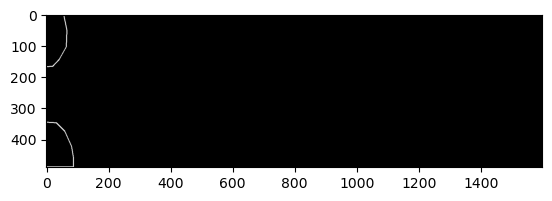

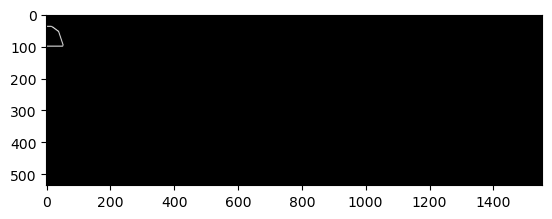

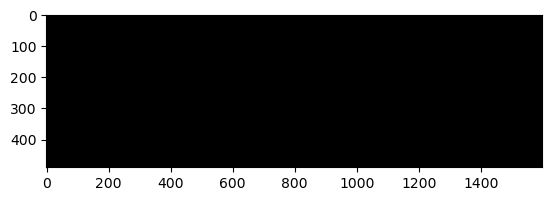

In [9]:
# Define the threshold for the detail of the polygone
threshold_detail_polygone = 0.005

# extract the hulls of each working zone
hull_finished_working_zones, img_finished_hull_working_zones, img_list_zones, images_iterations = \
    cvh.get_hulls(image_hulls_corner, working_zones, min_area = 10, threshold_detail_polygone=threshold_detail_polygone)


# Show the polygones depending on the working zones
plt.title("img_finished_hull_working_zones")
plt.imshow(cv2.cvtColor(img_finished_hull_working_zones, cv2.COLOR_BGR2RGB))
plt.show()

for z in img_list_zones:
    plt.imshow(cv2.cvtColor(z, cv2.COLOR_BGR2RGB))
    plt.show()



# Make a dilation for each Polynome depending on the working zone
* makea dilation depending in which zone the polynome is
* returns 
    *   image with dilated polyones
    *   group polygones dilated
    *   cropped image with polynones dilated


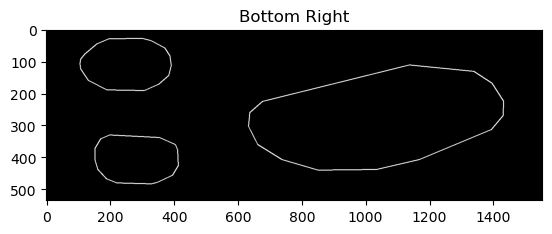

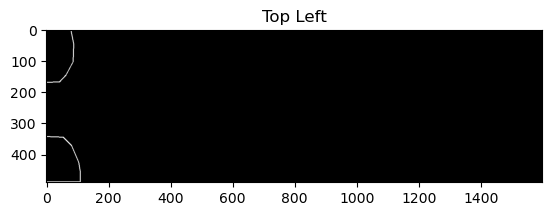

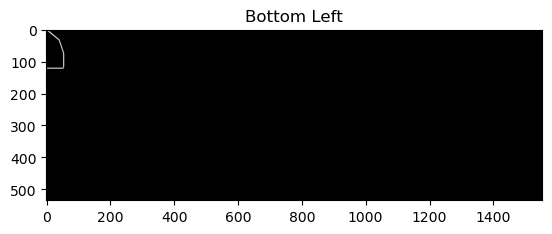

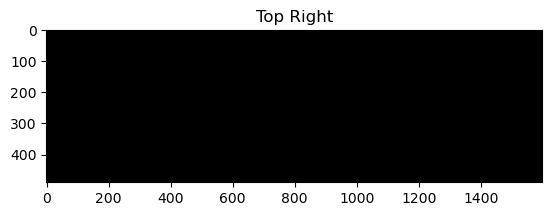

In [10]:
kernel = [(20,1),(20,1),(1,20),(1,20)]

# make the dilate of each polygone in each working zone
image_dilate_zones, grouped_polygones_dilate_zones, img_dilate_polygone_zones = \
    cvh.dilate_polygons(img_list_zones,kernel , threshold_detail_polygone=threshold_detail_polygone)


for i in range(len(img_dilate_polygone_zones)):
    if i == 0:
        plt.title("Bottom Right")
    elif i == 1:
        plt.title("Top Left")
    elif i == 2:
        plt.title("Bottom Left")
    elif i == 3:
        plt.title("Top Right")
    #plt.imshow(cv2.cvtColor(image_dilate_zones[i], cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(img_dilate_polygone_zones[i], cv2.COLOR_BGR2RGB))
    plt.show()


# Make trapezoids for each poylnone in accordance with the working zone.

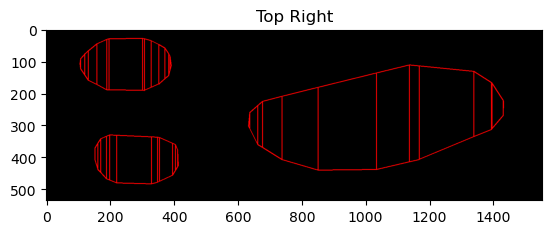

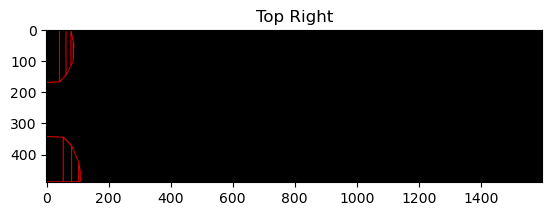

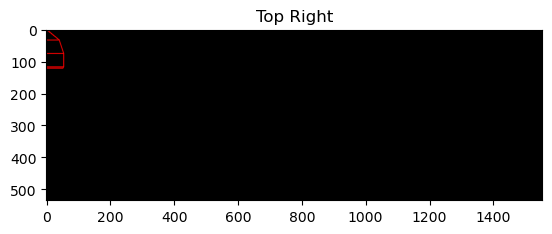

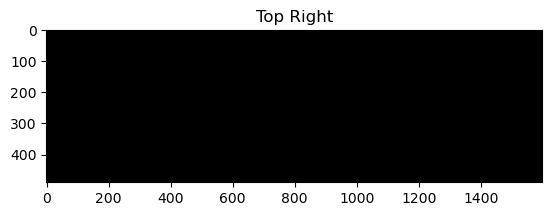

In [11]:
# make the trapezoids of each polygone in each working zone
polygones_zones = cvh.get_trapezoids(grouped_polygones_dilate_zones, img_dilate_polygone_zones, image)


# show the trapezoids
for polygone_groups, image_cropped_polygones in zip(polygones_zones,img_list_zones):
    image5 = np.zeros_like(image_cropped_polygones)
    for polygone in polygone_groups:
        for trap in polygone:
            # Draw the polygon on the image
            # Reshape the array to have shape (1, n, 2)
            pts = np.array([trap], np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(image5, [pts], True, (0, 0, 255), thickness=2)
    if i == 0:
        plt.title("Bottom Right")
    elif i == 1:
        plt.title("Top Left")
    elif i == 2:
        plt.title("Bottom Left")
    elif i == 3:
        plt.title("Top Right")
    plt.imshow(cv2.cvtColor(image5, cv2.COLOR_BGR2RGB))
    plt.show()
